In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
bm_train = pd.read_csv('bm_train.csv')
bm_test = pd.read_csv('bm_test.csv')

In [3]:
#Missing Values Imputation

In [4]:
bm_train['source'] = 'bm_train'
bm_test['source'] = 'bm_test'
bm_test['Item_Outlet_Sales'] = 0
data = pd.concat([bm_train, bm_test], sort = False)
print(bm_train.shape, bm_test.shape, data.shape)

(8523, 13) (5681, 13) (14204, 13)


In [5]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

miss_bool = data['Item_Weight'].isnull()

print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x].values[0])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [50]:
from scipy.stats import mode

In [51]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Type_Combined,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,249.8092,OUT049,1,0,1,3735.1380,bm_train,1,10,9
1,DRC01,5.92,1,0.019278,48.2692,OUT018,1,2,2,443.4228,bm_train,0,0,3
2,FDN15,17.50,0,0.016760,141.6180,OUT049,1,0,1,2097.2700,bm_train,1,10,9
3,FDX07,19.20,1,0.017834,182.0950,OUT010,3,2,0,732.3800,bm_train,1,11,0
4,NCD19,8.93,0,0.009780,53.8614,OUT013,0,2,1,994.7052,bm_train,2,22,1


In [7]:
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x.astype('str'),nan_policy = 'omit').mode[0]))

In [70]:
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,nan,Small,Medium,Medium


In [78]:
data[['Outlet_Type','Outlet_Size','source']].groupby(['Outlet_Type','Outlet_Size']).count()

source
Outlet_Type Outlet_Size        
0           2               880
            3               925
1           0              1553
            1              1550
            2              6191
2           1              1546
3           1              1559

In [ ]:
missing_o = data['Outlet_Size'].isnull() 

In [10]:
data.loc[missing_o,'Outlet_Size'] = data.loc[missing_o,'Outlet_Type'].apply(lambda x : outlet_size_mode[x])

<AxesSubplot:>

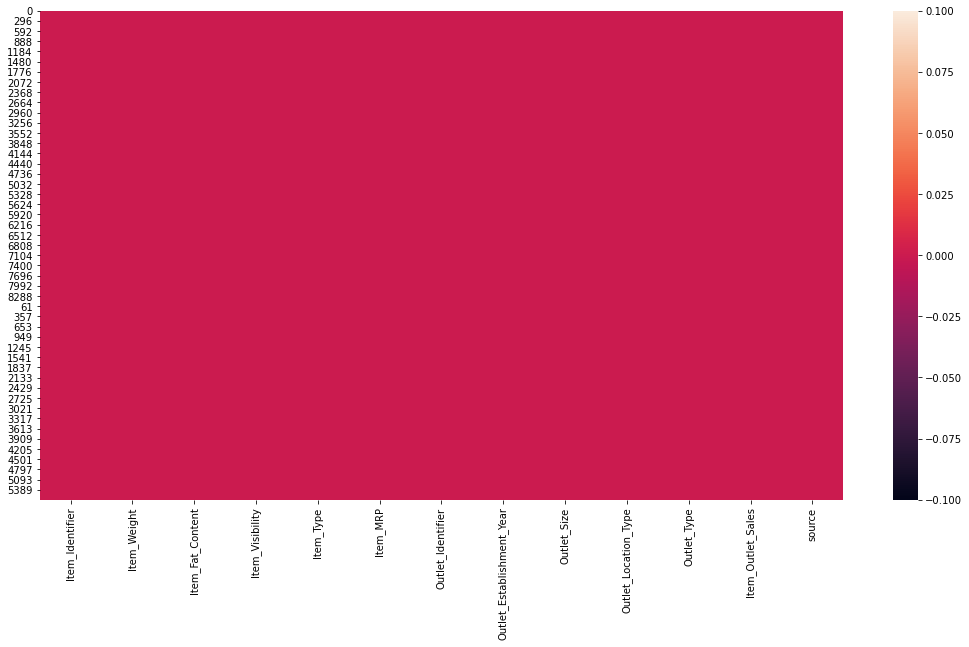

In [11]:
plt.figure(figsize=(18,9))
sns.heatmap(data.isnull())

In [12]:
#Modify Item_Visibility

#We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.


In [13]:
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

missing_values = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(missing_values))
data.loc[missing_values,'Item_Visibility'] = data.loc[missing_values,'Item_Identifier'].apply(lambda x: visibility_avg.at[x, 'Item_Visibility'])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [14]:


data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()


Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

<AxesSubplot:xlabel='Item_Type_Combined'>

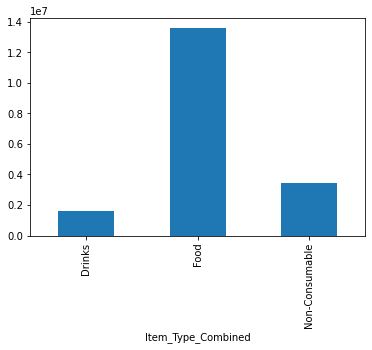

In [15]:
data.groupby('Item_Type_Combined').sum()['Item_Outlet_Sales'].plot.bar()

<AxesSubplot:xlabel='Outlet_Establishment_Year'>

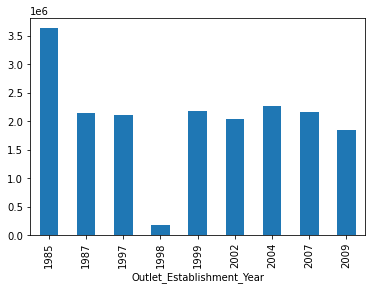

In [16]:
data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum().plot.bar()

In [17]:
data['Outlet_Years'] = 2009 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        11.169319
std          8.371664
min          0.000000
25%          5.000000
50%         10.000000
75%         22.000000
max         24.000000
Name: Outlet_Years, dtype: float64

In [18]:
data.nunique()

Item_Identifier               1559
Item_Weight                    628
Item_Fat_Content                 2
Item_Visibility              13688
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
Item_Type_Combined               3
Outlet_Years                     9
dtype: int64

In [19]:
data.drop(['Item_Type','Outlet_Establishment_Year'], axis = 'columns', inplace=True)

In [20]:
data.nunique()

Item_Identifier          1559
Item_Weight               628
Item_Fat_Content            2
Item_Visibility         13688
Item_MRP                 8052
Outlet_Identifier          10
Outlet_Size                 4
Outlet_Location_Type        3
Outlet_Type                 4
Item_Outlet_Sales        3494
source                      2
Item_Type_Combined          3
Outlet_Years                9
dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()

In [23]:
data['Outlet']=le.fit_transform(data['Outlet_Identifier'])
var = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Type_Combined','Outlet']
lee = LabelEncoder()
for i in var:
    data[i]=lee.fit_transform(data[i])

In [24]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Type_Combined,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,249.8092,OUT049,1,0,1,3735.1380,bm_train,1,10,9
1,DRC01,5.92,1,0.019278,48.2692,OUT018,1,2,2,443.4228,bm_train,0,0,3
2,FDN15,17.50,0,0.016760,141.6180,OUT049,1,0,1,2097.2700,bm_train,1,10,9
3,FDX07,19.20,1,0.017834,182.0950,OUT010,3,2,0,732.3800,bm_train,1,11,0
4,NCD19,8.93,0,0.009780,53.8614,OUT013,0,2,1,994.7052,bm_train,2,22,1


In [25]:
#Divide into test and train:
train = data.loc[data['source']=="bm_train"]
test = data.loc[data['source']=="bm_test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

C:\Users\Saurabh kalani\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,249.8092,OUT049,1,0,1,3735.1380,1,10,9
1,DRC01,5.92,1,0.019278,48.2692,OUT018,1,2,2,443.4228,0,0,3
2,FDN15,17.50,0,0.016760,141.6180,OUT049,1,0,1,2097.2700,1,10,9
3,FDX07,19.20,1,0.017834,182.0950,OUT010,3,2,0,732.3800,1,11,0
4,NCD19,8.93,0,0.009780,53.8614,OUT013,0,2,1,994.7052,2,22,1


In [27]:
x_train = train.drop(['Item_Outlet_Sales','Outlet_Identifier','Item_Identifier'],axis = 1).values

In [28]:
x_train

array([[9.30000000e+00, 0.00000000e+00, 1.60473010e-02, ...,
        1.00000000e+00, 1.00000000e+01, 9.00000000e+00],
       [5.92000000e+00, 1.00000000e+00, 1.92782160e-02, ...,
        0.00000000e+00, 0.00000000e+00, 3.00000000e+00],
       [1.75000000e+01, 0.00000000e+00, 1.67600750e-02, ...,
        1.00000000e+00, 1.00000000e+01, 9.00000000e+00],
       ...,
       [1.06000000e+01, 0.00000000e+00, 3.51862710e-02, ...,
        2.00000000e+00, 5.00000000e+00, 6.00000000e+00],
       [7.21000000e+00, 1.00000000e+00, 1.45220646e-01, ...,
        1.00000000e+00, 0.00000000e+00, 3.00000000e+00],
       [1.48000000e+01, 0.00000000e+00, 4.48782800e-02, ...,
        0.00000000e+00, 1.20000000e+01, 8.00000000e+00]])

In [29]:
y_train = train['Item_Outlet_Sales'].values

In [30]:
x_test = test.drop(['Outlet_Identifier','Item_Identifier'],axis = 1).values

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()

In [33]:
x_train = scaler.fit_transform(x_train)

In [34]:
x_test = scaler.transform(x_test)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [36]:
x_train.shape

(8523, 10)

In [37]:
model = Sequential()

model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [38]:
model.fit(x = x_train,y=y_train, batch_size = 128, epochs = 400)

Epoch 1/400
67/67 [==============================] - 2s 2ms/step - loss: 7668693.5000
Epoch 2/400
67/67 [==============================] - 0s 1ms/step - loss: 7659429.5000
Epoch 3/400
67/67 [==============================] - 0s 1ms/step - loss: 7620117.0000
Epoch 4/400
67/67 [==============================] - 0s 1ms/step - loss: 7499955.5000
Epoch 5/400
67/67 [==============================] - 0s 1ms/step - loss: 7231887.0000
Epoch 6/400
67/67 [==============================] - 0s 1ms/step - loss: 6748495.0000
Epoch 7/400
67/67 [==============================] - 0s 909us/step - loss: 6018815.0000
Epoch 8/400
67/67 [==============================] - 0s 985us/step - loss: 5076343.0000
Epoch 9/400
67/67 [==============================] - 0s 909us/step - loss: 4067128.0000
Epoch 10/400
67/67 [==============================] - 0s 985us/step - loss: 3257903.2500
Epoch 11/400
67/67 [==============================] - 0s 985us/step - loss: 2806582.5000
Epoch 12/400
67/67 [======================

67/67 [==============================] - 0s 931us/step - loss: 1397581.1250
Epoch 94/400
67/67 [==============================] - 0s 909us/step - loss: 1397380.0000
Epoch 95/400
67/67 [==============================] - 0s 985us/step - loss: 1397418.5000
Epoch 96/400
67/67 [==============================] - 0s 909us/step - loss: 1396539.6250
Epoch 97/400
67/67 [==============================] - 0s 909us/step - loss: 1395740.8750
Epoch 98/400
67/67 [==============================] - 0s 909us/step - loss: 1395002.2500
Epoch 99/400
67/67 [==============================] - 0s 909us/step - loss: 1394244.1250
Epoch 100/400
67/67 [==============================] - 0s 985us/step - loss: 1393395.6250
Epoch 101/400
67/67 [==============================] - 0s 909us/step - loss: 1392870.2500
Epoch 102/400
67/67 [==============================] - 0s 909us/step - loss: 1391970.0000
Epoch 103/400
67/67 [==============================] - 0s 985us/step - loss: 1390477.7500
Epoch 104/400
67/67 [=========

67/67 [==============================] - 0s 946us/step - loss: 1267911.0000
Epoch 185/400
67/67 [==============================] - 0s 909us/step - loss: 1267229.1250
Epoch 186/400
67/67 [==============================] - 0s 1ms/step - loss: 1263860.3750
Epoch 187/400
67/67 [==============================] - 0s 985us/step - loss: 1264190.7500
Epoch 188/400
67/67 [==============================] - 0s 985us/step - loss: 1262263.1250
Epoch 189/400
67/67 [==============================] - 0s 1ms/step - loss: 1261135.7500
Epoch 190/400
67/67 [==============================] - 0s 1ms/step - loss: 1260301.0000
Epoch 191/400
67/67 [==============================] - 0s 985us/step - loss: 1258676.2500
Epoch 192/400
67/67 [==============================] - 0s 1ms/step - loss: 1257250.2500
Epoch 193/400
67/67 [==============================] - 0s 1ms/step - loss: 1256520.7500
Epoch 194/400
67/67 [==============================] - 0s 985us/step - loss: 1255055.0000
Epoch 195/400
67/67 [=============

Epoch 276/400
67/67 [==============================] - 0s 1ms/step - loss: 1193358.0000
Epoch 277/400
67/67 [==============================] - 0s 985us/step - loss: 1190990.8750
Epoch 278/400
67/67 [==============================] - 0s 2ms/step - loss: 1191755.7500
Epoch 279/400
67/67 [==============================] - 0s 947us/step - loss: 1192470.0000
Epoch 280/400
67/67 [==============================] - 0s 985us/step - loss: 1190959.6250
Epoch 281/400
67/67 [==============================] - 0s 1ms/step - loss: 1190206.2500
Epoch 282/400
67/67 [==============================] - 0s 909us/step - loss: 1189661.6250
Epoch 283/400
67/67 [==============================] - 0s 909us/step - loss: 1189249.6250
Epoch 284/400
67/67 [==============================] - 0s 1ms/step - loss: 1190203.0000
Epoch 285/400
67/67 [==============================] - 0s 2ms/step - loss: 1188821.6250
Epoch 286/400
67/67 [==============================] - 0s 985us/step - loss: 1188393.1250
Epoch 287/400
67/67 

67/67 [==============================] - 0s 2ms/step - loss: 1169057.3750
Epoch 368/400
67/67 [==============================] - 0s 2ms/step - loss: 1170978.5000
Epoch 369/400
67/67 [==============================] - 0s 1ms/step - loss: 1169068.0000
Epoch 370/400
67/67 [==============================] - 0s 2ms/step - loss: 1168615.8750
Epoch 371/400
67/67 [==============================] - 0s 2ms/step - loss: 1168504.5000
Epoch 372/400
67/67 [==============================] - 0s 2ms/step - loss: 1168609.2500
Epoch 373/400
67/67 [==============================] - 0s 1ms/step - loss: 1168204.2500
Epoch 374/400
67/67 [==============================] - 0s 2ms/step - loss: 1168255.1250
Epoch 375/400
67/67 [==============================] - 0s 2ms/step - loss: 1168068.7500
Epoch 376/400
67/67 [==============================] - 0s 1ms/step - loss: 1168057.0000
Epoch 377/400
67/67 [==============================] - 0s 1ms/step - loss: 1167451.0000
Epoch 378/400
67/67 [=========================

In [39]:
predictions = model.predict(x_test)

In [40]:
predictions

array([[1958.4745],
       [1621.5619],
       [1098.4048],
       ...,
       [1935.3383],
       [3692.9998],
       [1306.8698]], dtype=float32)

In [41]:
final=bm_test

In [42]:
final['Item_Outlet_Sales'] = predictions

In [43]:
final.to_csv("bm_sol_3.csv",index=False)

In [44]:
model = Sequential()

model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [45]:
model.fit(x = x_train,y=y_train, batch_size = 128, epochs = 1000)

Epoch 1/1000
67/67 [==============================] - 1s 1ms/step - loss: 7664100.0000
Epoch 2/1000
67/67 [==============================] - 0s 1ms/step - loss: 7628289.0000
Epoch 3/1000
67/67 [==============================] - 0s 1ms/step - loss: 7453053.5000
Epoch 4/1000
67/67 [==============================] - 0s 1ms/step - loss: 6873879.5000
Epoch 5/1000
67/67 [==============================] - 0s 1ms/step - loss: 5663250.0000
Epoch 6/1000
67/67 [==============================] - 0s 1ms/step - loss: 4058992.7500
Epoch 7/1000
67/67 [==============================] - 0s 1ms/step - loss: 2919462.0000
Epoch 8/1000
67/67 [==============================] - 0s 1ms/step - loss: 2602637.7500
Epoch 9/1000
67/67 [==============================] - 0s 1ms/step - loss: 2556989.7500
Epoch 10/1000
67/67 [==============================] - 0s 1ms/step - loss: 2527717.0000
Epoch 11/1000
67/67 [==============================] - 0s 1ms/step - loss: 2498287.7500
Epoch 12/1000
67/67 [====================

67/67 [==============================] - 0s 833us/step - loss: 1394955.7500
Epoch 93/1000
67/67 [==============================] - 0s 985us/step - loss: 1394155.2500
Epoch 94/1000
67/67 [==============================] - 0s 985us/step - loss: 1392453.2500
Epoch 95/1000
67/67 [==============================] - 0s 909us/step - loss: 1393003.0000
Epoch 96/1000
67/67 [==============================] - 0s 909us/step - loss: 1391344.5000
Epoch 97/1000
67/67 [==============================] - 0s 909us/step - loss: 1390489.0000
Epoch 98/1000
67/67 [==============================] - 0s 985us/step - loss: 1389398.3750
Epoch 99/1000
67/67 [==============================] - 0s 909us/step - loss: 1388623.0000
Epoch 100/1000
67/67 [==============================] - 0s 909us/step - loss: 1386797.8750
Epoch 101/1000
67/67 [==============================] - 0s 909us/step - loss: 1385497.2500
Epoch 102/1000
67/67 [==============================] - 0s 909us/step - loss: 1383875.2500
Epoch 103/1000
67/67 

67/67 [==============================] - 0s 985us/step - loss: 1220750.0000
Epoch 183/1000
67/67 [==============================] - 0s 909us/step - loss: 1220278.2500
Epoch 184/1000
67/67 [==============================] - 0s 833us/step - loss: 1218009.2500
Epoch 185/1000
67/67 [==============================] - 0s 909us/step - loss: 1217220.1250
Epoch 186/1000
67/67 [==============================] - 0s 1ms/step - loss: 1215593.0000
Epoch 187/1000
67/67 [==============================] - 0s 1ms/step - loss: 1215083.5000
Epoch 188/1000
67/67 [==============================] - 0s 1ms/step - loss: 1212723.2500
Epoch 189/1000
67/67 [==============================] - 0s 1ms/step - loss: 1213034.1250
Epoch 190/1000
67/67 [==============================] - 0s 985us/step - loss: 1212192.0000
Epoch 191/1000
67/67 [==============================] - 0s 758us/step - loss: 1210530.7500
Epoch 192/1000
67/67 [==============================] - 0s 957us/step - loss: 1209273.1250
Epoch 193/1000
67/67 [

Epoch 273/1000
67/67 [==============================] - 0s 909us/step - loss: 1168719.6250
Epoch 274/1000
67/67 [==============================] - 0s 909us/step - loss: 1168681.1250
Epoch 275/1000
67/67 [==============================] - 0s 909us/step - loss: 1168051.0000
Epoch 276/1000
67/67 [==============================] - 0s 909us/step - loss: 1167531.7500
Epoch 277/1000
67/67 [==============================] - 0s 985us/step - loss: 1166666.0000
Epoch 278/1000
67/67 [==============================] - 0s 833us/step - loss: 1166355.1250
Epoch 279/1000
67/67 [==============================] - 0s 909us/step - loss: 1167036.5000
Epoch 280/1000
67/67 [==============================] - 0s 1ms/step - loss: 1166830.8750
Epoch 281/1000
67/67 [==============================] - 0s 909us/step - loss: 1166529.0000
Epoch 282/1000
67/67 [==============================] - 0s 985us/step - loss: 1165633.5000
Epoch 283/1000
67/67 [==============================] - 0s 909us/step - loss: 1165350.6250
E

67/67 [==============================] - 0s 985us/step - loss: 1153673.5000
Epoch 364/1000
67/67 [==============================] - 0s 985us/step - loss: 1154249.0000
Epoch 365/1000
67/67 [==============================] - 0s 1ms/step - loss: 1154241.2500
Epoch 366/1000
67/67 [==============================] - 0s 1ms/step - loss: 1153833.2500
Epoch 367/1000
67/67 [==============================] - 0s 1ms/step - loss: 1153399.3750
Epoch 368/1000
67/67 [==============================] - 0s 909us/step - loss: 1154850.3750
Epoch 369/1000
67/67 [==============================] - 0s 1ms/step - loss: 1153986.6250
Epoch 370/1000
67/67 [==============================] - 0s 985us/step - loss: 1152942.7500
Epoch 371/1000
67/67 [==============================] - 0s 909us/step - loss: 1153423.5000
Epoch 372/1000
67/67 [==============================] - 0s 985us/step - loss: 1152688.6250
Epoch 373/1000
67/67 [==============================] - 0s 985us/step - loss: 1153998.8750
Epoch 374/1000
67/67 [

67/67 [==============================] - 0s 1ms/step - loss: 1151578.7500
Epoch 455/1000
67/67 [==============================] - 0s 909us/step - loss: 1149969.0000
Epoch 456/1000
67/67 [==============================] - 0s 1ms/step - loss: 1150014.7500
Epoch 457/1000
67/67 [==============================] - 0s 1ms/step - loss: 1149969.2500
Epoch 458/1000
67/67 [==============================] - 0s 909us/step - loss: 1148236.2500
Epoch 459/1000
67/67 [==============================] - 0s 833us/step - loss: 1150558.3750
Epoch 460/1000
67/67 [==============================] - 0s 985us/step - loss: 1148490.6250
Epoch 461/1000
67/67 [==============================] - 0s 1ms/step - loss: 1150372.7500
Epoch 462/1000
67/67 [==============================] - 0s 1ms/step - loss: 1149063.6250
Epoch 463/1000
67/67 [==============================] - 0s 1ms/step - loss: 1148796.1250
Epoch 464/1000
67/67 [==============================] - 0s 1ms/step - loss: 1148928.7500
Epoch 465/1000
67/67 [======

67/67 [==============================] - 0s 1ms/step - loss: 1146775.8750
Epoch 545/1000
67/67 [==============================] - 0s 985us/step - loss: 1147722.3750
Epoch 546/1000
67/67 [==============================] - 0s 985us/step - loss: 1147666.7500
Epoch 547/1000
67/67 [==============================] - 0s 909us/step - loss: 1147412.8750
Epoch 548/1000
67/67 [==============================] - 0s 985us/step - loss: 1148018.8750
Epoch 549/1000
67/67 [==============================] - 0s 909us/step - loss: 1146453.3750
Epoch 550/1000
67/67 [==============================] - 0s 909us/step - loss: 1147806.7500
Epoch 551/1000
67/67 [==============================] - 0s 909us/step - loss: 1147393.1250
Epoch 552/1000
67/67 [==============================] - 0s 985us/step - loss: 1149155.8750
Epoch 553/1000
67/67 [==============================] - 0s 985us/step - loss: 1147581.8750
Epoch 554/1000
67/67 [==============================] - 0s 1ms/step - loss: 1147093.5000
Epoch 555/1000
67/

67/67 [==============================] - 0s 1ms/step - loss: 1146136.2500
Epoch 636/1000
67/67 [==============================] - 0s 1ms/step - loss: 1145992.8750
Epoch 637/1000
67/67 [==============================] - 0s 1ms/step - loss: 1146421.2500
Epoch 638/1000
67/67 [==============================] - 0s 1ms/step - loss: 1146980.5000
Epoch 639/1000
67/67 [==============================] - 0s 2ms/step - loss: 1146330.8750
Epoch 640/1000
67/67 [==============================] - 0s 1ms/step - loss: 1146408.7500
Epoch 641/1000
67/67 [==============================] - 0s 1ms/step - loss: 1146250.1250
Epoch 642/1000
67/67 [==============================] - 0s 1ms/step - loss: 1145346.0000
Epoch 643/1000
67/67 [==============================] - 0s 1ms/step - loss: 1146758.7500
Epoch 644/1000
67/67 [==============================] - 0s 1ms/step - loss: 1145675.8750
Epoch 645/1000
67/67 [==============================] - 0s 1ms/step - loss: 1145832.0000
Epoch 646/1000
67/67 [==============

67/67 [==============================] - 0s 985us/step - loss: 1145954.6250
Epoch 726/1000
67/67 [==============================] - 0s 909us/step - loss: 1144886.7500
Epoch 727/1000
67/67 [==============================] - 0s 909us/step - loss: 1145454.5000
Epoch 728/1000
67/67 [==============================] - 0s 909us/step - loss: 1144719.1250
Epoch 729/1000
67/67 [==============================] - 0s 909us/step - loss: 1144485.6250
Epoch 730/1000
67/67 [==============================] - 0s 931us/step - loss: 1144979.7500
Epoch 731/1000
67/67 [==============================] - 0s 985us/step - loss: 1145012.2500
Epoch 732/1000
67/67 [==============================] - 0s 909us/step - loss: 1145738.6250
Epoch 733/1000
67/67 [==============================] - 0s 985us/step - loss: 1145231.1250
Epoch 734/1000
67/67 [==============================] - 0s 985us/step - loss: 1144907.2500
Epoch 735/1000
67/67 [==============================] - 0s 985us/step - loss: 1145346.5000
Epoch 736/1000

67/67 [==============================] - 0s 909us/step - loss: 1144295.5000
Epoch 816/1000
67/67 [==============================] - 0s 1ms/step - loss: 1143971.2500
Epoch 817/1000
67/67 [==============================] - 0s 909us/step - loss: 1143971.6250
Epoch 818/1000
67/67 [==============================] - 0s 909us/step - loss: 1144051.8750
Epoch 819/1000
67/67 [==============================] - 0s 985us/step - loss: 1144544.0000
Epoch 820/1000
67/67 [==============================] - 0s 1ms/step - loss: 1145448.2500
Epoch 821/1000
67/67 [==============================] - 0s 1ms/step - loss: 1144576.8750
Epoch 822/1000
67/67 [==============================] - 0s 1ms/step - loss: 1144785.2500
Epoch 823/1000
67/67 [==============================] - 0s 1ms/step - loss: 1143796.2500
Epoch 824/1000
67/67 [==============================] - 0s 985us/step - loss: 1145235.8750
Epoch 825/1000
67/67 [==============================] - 0s 909us/step - loss: 1143878.8750
Epoch 826/1000
67/67 [==

67/67 [==============================] - 0s 833us/step - loss: 1143268.0000
Epoch 906/1000
67/67 [==============================] - 0s 909us/step - loss: 1143530.5000
Epoch 907/1000
67/67 [==============================] - 0s 985us/step - loss: 1142804.8750
Epoch 908/1000
67/67 [==============================] - 0s 909us/step - loss: 1143488.3750
Epoch 909/1000
67/67 [==============================] - 0s 909us/step - loss: 1143036.0000
Epoch 910/1000
67/67 [==============================] - 0s 758us/step - loss: 1143856.0000
Epoch 911/1000
67/67 [==============================] - 0s 833us/step - loss: 1144378.3750
Epoch 912/1000
67/67 [==============================] - 0s 985us/step - loss: 1142974.7500
Epoch 913/1000
67/67 [==============================] - 0s 985us/step - loss: 1142985.5000
Epoch 914/1000
67/67 [==============================] - 0s 909us/step - loss: 1143916.5000
Epoch 915/1000
67/67 [==============================] - 0s 909us/step - loss: 1142929.5000
Epoch 916/1000

67/67 [==============================] - 0s 985us/step - loss: 1142870.6250
Epoch 996/1000
67/67 [==============================] - 0s 985us/step - loss: 1142737.8750
Epoch 997/1000
67/67 [==============================] - 0s 909us/step - loss: 1143014.8750
Epoch 998/1000
67/67 [==============================] - 0s 909us/step - loss: 1143059.7500
Epoch 999/1000
67/67 [==============================] - 0s 909us/step - loss: 1142260.8750
Epoch 1000/1000
67/67 [==============================] - 0s 909us/step - loss: 1143156.7500


In [46]:
predictions = model.predict(x_test)

In [47]:
final=bm_test

In [48]:
final['Item_Outlet_Sales'] = predictions

In [49]:
final.to_csv("bm_sol_3.csv",index=False)